# Strava

When I go on runs, I love to use Strava mostly because they have awesome looking maps I get to look at after I run. I started wondering what all my runs over my many years on the app look like. So, I downloaded my entire account.

Strava stores all of the activities in what's called a GPX file format, or GPS Exchange Format. Basically, it's a textfile with geographical data about your activity.

After some quick research, it looks like there's a package that helps parse these GPX files.

In [ ]:
import gpxpy
import gpxpy.gpx
import pandas as pd
import matplotlib.pyplot as plt

gpx = gpxpy.parse(open('../data/strava/activities/3006031304.gpx'))

print(gpx)

GPX(tracks=[GPXTrack(name='Leisure', segments=[GPXTrackSegment(points=[...])])])


So each GPX file contains a list called "tracks", which has another list inside it called "segments." The "segments" list is where all the coordinates are that create each map.

In [2]:
route_info = []

for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                'latitude': point.latitude,
                'longitude': point.longitude,
                'elevation': point.elevation
            })

route_df = pd.DataFrame(route_info)
print(route_df.head(10))

    latitude  longitude  elevation
0  42.366715 -72.528549       72.2
1  42.366704 -72.528489       72.2
2  42.366687 -72.528449       72.2
3  42.366657 -72.528454       72.1
4  42.366616 -72.528463       72.1
5  42.366579 -72.528496       72.0
6  42.366553 -72.528514       71.9
7  42.366502 -72.528556       71.8
8  42.366467 -72.528587       71.7
9  42.366435 -72.528615       71.6


Great! Now, we have a dataframe of coordinates. Let's convert them to points and connect them through the LineString function.

In [9]:
import geopandas as gp
from shapely.geometry import LineString

route_gdf = gp.GeoDataFrame(
    route_df, geometry=gp.points_from_xy(route_df.longitude, route_df.latitude), crs="EPSG:4326"
)

route_line = LineString(route_gdf.geometry.tolist())

route_line_gdf = gp.GeoDataFrame(geometry=[route_line], crs="EPSG:4326")

print(route_line_gdf.head(10))

                                            geometry
0  LINESTRING (-72.52855 42.36672, -72.52849 42.3...


Now that we have a LineString made up of all the points in our activity, let's plot it on a map.

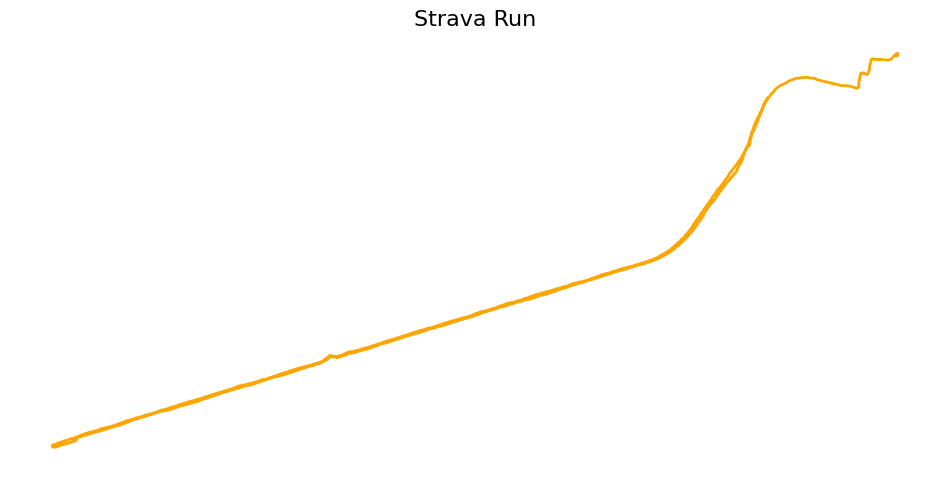

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))

route_line_gdf.plot(ax=ax, linewidth=2, color='orange')

ax.set_axis_off()
ax.set_title('Strava Run', fontsize=16)

plt.show()

Great! Now let's see if we can do this for all of my activities.

In [51]:
import os
import gzip
import xml.etree.ElementTree as ET

data_dir = '../data/strava/activities/'

tcx_routes = []

tcx_file = "5632416250.tcx.gz"

tcx_full_path = os.path.join(data_dir, tcx_file)

with gzip.open(tcx_full_path, 'rt') as f:
    tree = ET.parse(f)
    root = tree.getroot()
    
    print(root.tag)

    namespace_uri = root.tag.split('}')[0].strip('{')
    namespace = {'ns': namespace_uri}
    
    for track in root.findall('.//ns:Track', namespace):

        for trackpoint in track.findall('ns:Trackpoint', namespace):

            for child in trackpoint:
                print(child.tag, child.text)
            # position = trackpoint.find('ns:Position', namespace)

            # print(position)

            # if position is not None:
            #     lat = position.find('ns:LatitudeDegrees', namespace)
            #     lon = position.find('ns:LongitudeDegrees', namespace)
            #     if lat is not None and lon is not None:
            #         tcx_routes.append({
            #             'latitude': float(lat.text),
            #             'longitude': float(lon.text)
            #         })

tcx_df = pd.DataFrame(tcx_routes)
print(tcx_df.head(10))

{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}TrainingCenterDatabase
{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time 2021-05-12T21:06:29+00:00
{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time 2021-05-12T21:06:30+00:00
{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time 2021-05-12T21:06:31+00:00
{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time 2021-05-12T21:06:32+00:00
{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time 2021-05-12T21:06:33+00:00
{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time 2021-05-12T21:06:34+00:00
{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time 2021-05-12T21:06:35+00:00
{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time 2021-05-12T21:06:36+00:00
{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time 2021-05-12T21:06:37+00:00
{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time 2021-05-12T21:06:38+00:00
{http:/

In [52]:


folder_path = '../data/strava/activities/'

strava_routes = []

for filename in os.listdir(folder_path):
    
    route_info = []
    full_path = os.path.join(folder_path, filename)

    if filename.endswith('.gpx'):
        gpx = gpxpy.parse(open(os.path.join(folder_path, filename)))

        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    route_info.append({
                        'latitude': point.latitude,
                        'longitude': point.longitude,
                        'elevation': point.elevation
                    })

    elif filename.endswith('.gpx.gz'):
        with gzip.open(full_path, 'rt') as f:
            gpx_content = f.read()
            gpx = gpxpy.parse(gpx_content)

        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    route_info.append({
                        'latitude': point.latitude,
                        'longitude': point.longitude,
                        'elevation': point.elevation
                    })

    elif filename.endswith('.tcx') or filename.endswith('.tcx.gz'):
        if filename.endswith('.tcx.gz'):
            with gzip.open(full_path, 'rt') as f:
                content = f.read().lstrip() 
                tree = ET.ElementTree(ET.fromstring(content))
        else:

            tree = ET.parse(full_path)

        root = tree.getroot()
        namespace_uri = root.tag.split('}')[0].strip('{')
        namespace = {'ns': namespace_uri}

        ns = {'tcx': namespace_uri}

        for tp in root.findall('.//tcx:Trackpoint', ns):
            pos = tp.find('tcx:Position', ns)
            ele = tp.find('tcx:AltitudeMeters', ns)

            lat = lon = None
            if pos is not None:
                lat = pos.find('tcx:LatitudeDegrees', ns)
                lon = pos.find('tcx:LongitudeDegrees', ns)

            if lat is not None and lon is not None:
                route_info.append({
                    'latitude': float(lat.text),
                    'longitude': float(lon.text),
                    'elevation': float(ele.text) if ele is not None else None
                })

    # --- If format not supported ---
    else:
        print(f"Skipping unsupported file: {filename}")
        continue

    
    print(route_info[:3])
    
    if route_info:
        route_df = pd.DataFrame(route_info)

        if {"latitude", "longitude"}.issubset(route_df.columns):
            route_gdf = gp.GeoDataFrame(
                route_df,
                geometry=gp.points_from_xy(route_df["longitude"], route_df["latitude"]),
                crs="EPSG:4326"
            )
            route_line = LineString(route_gdf.geometry.tolist())

            strava_routes.append(route_line)
    else:
        print(f"Skipped {filename}: no route points")

strava_routes_gdf = gp.GeoDataFrame(geometry=strava_routes, crs="EPSG:4326")
print(strava_routes_gdf.head(10))

[{'latitude': 40.675429, 'longitude': -73.962665, 'elevation': 38.8}, {'latitude': 40.675392, 'longitude': -73.962665, 'elevation': 38.7}, {'latitude': 40.675316, 'longitude': -73.962573, 'elevation': 38.7}]
[]
Skipped 5706617377.tcx.gz: no route points
[]
Skipped 13503323657.tcx.gz: no route points
[{'latitude': 42.416038, 'longitude': -72.515386, 'elevation': 72.4}, {'latitude': 42.416038, 'longitude': -72.515386, 'elevation': 72.4}, {'latitude': 42.416037, 'longitude': -72.515374, 'elevation': 72.2}]
[]
Skipped 5615385123.tcx.gz: no route points
[]
Skipped 13922784985.tcx.gz: no route points
[]
Skipped 4941779698.tcx.gz: no route points
[{'latitude': 42.413955, 'longitude': -72.51841, 'elevation': 76.0}, {'latitude': 42.413955, 'longitude': -72.51841, 'elevation': 76.0}, {'latitude': 42.413951, 'longitude': -72.518391, 'elevation': 76.0}]
[]
Skipped 14571530705.tcx.gz: no route points
[]
Skipped 5451930641.tcx.gz: no route points
[]
Skipped 4671260303.tcx.gz: no route points
[{'lati

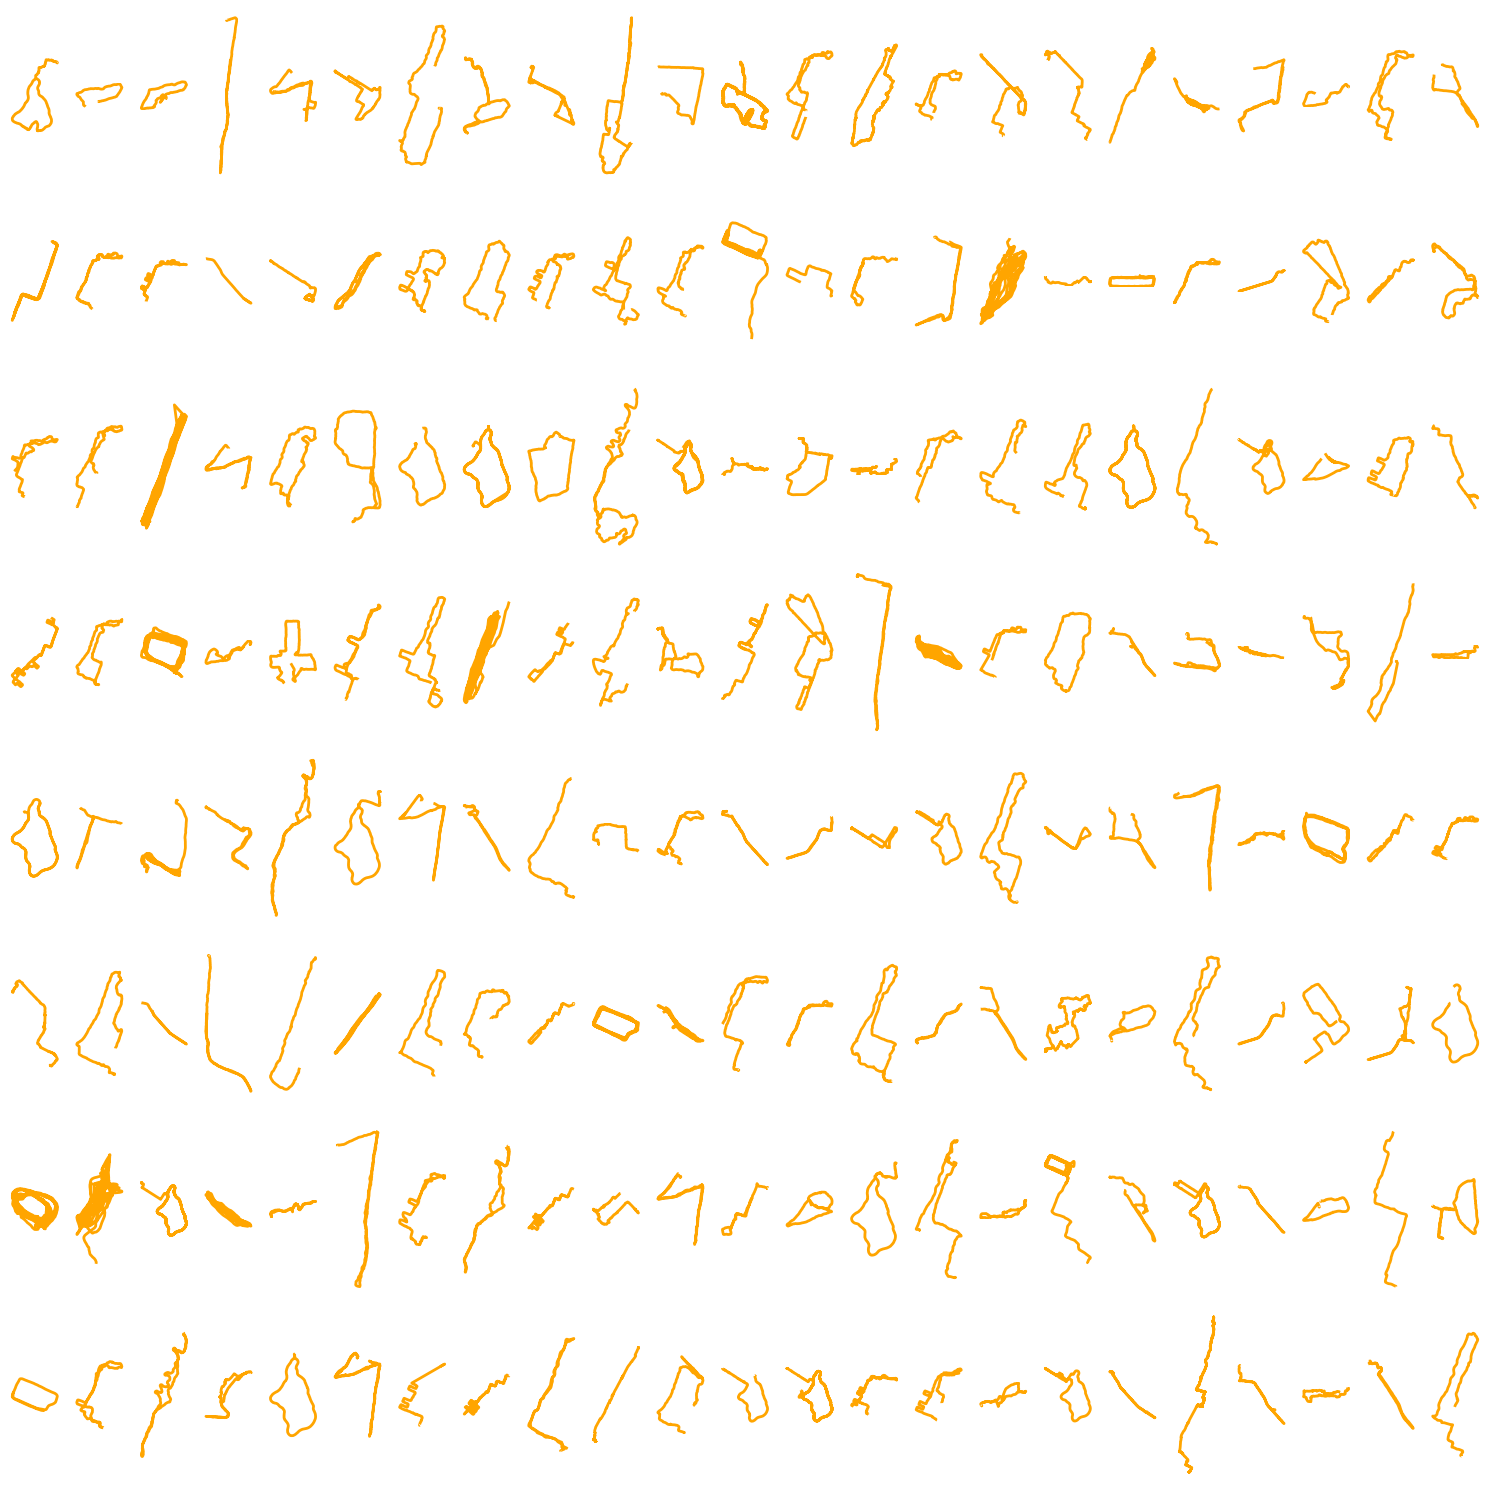

In [56]:
n_routes = len(strava_routes_gdf)
n_cols = 23
n_rows = 8

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

for routes, ax in zip(strava_routes_gdf.geometry, axes.flatten()):
    gp.GeoDataFrame(geometry=[routes], crs="EPSG:4326").plot(ax=ax, linewidth=2, color='orange')
    ax.set_axis_off()

plt.tight_layout()
plt.show()



I just learned there's another kind of activity file called a .fit file. Let's figure out how to parse that.

In [ ]:
import fitdecode
from io import BytesIO


fit_lines = []
noel_path = "../data/noel_strava"

for filename in os.listdir(noel_path):
    fit_records = []
    noel_full_path = os.path.join(noel_path, filename)

    print(f"Parsing {filename}")

    if filename.endswith('.fit.gz'):
        with gzip.open(noel_full_path, 'rb') as f:
            fit_content = f.read()
        
        fit_object = BytesIO(fit_content)


    with fitdecode.FitReader(fit_object) as fit_reader:

        for frame in fit_reader:
            # The yielded frame object is of one of the following types:
            # * fitdecode.FitHeader (FIT_FRAME_HEADER)
            # * fitdecode.FitDefinitionMessage (FIT_FRAME_DEFINITION)
            # * fitdecode.FitDataMessage (FIT_FRAME_DATA)
            # * fitdecode.FitCRC (FIT_FRAME_CRC)

            if frame.frame_type == fitdecode.FIT_FRAME_DATA and frame.name == "record":
                # Here, frame is a FitDataMessage object.
                # A FitDataMessage object contains decoded values that
                # are directly usable in your script logic.
                record_data = {}
                for field in frame.fields:
                    record_data[field.name] = field.value
                if not record_data:
                    continue
                else:
                    fit_records.append(record_data)

        noel_df = pd.DataFrame(fit_records)
        if {"position_lat", "position_long"}.issubset(noel_df.columns):

            noel_df_clean = noel_df.dropna(subset=["position_lat", "position_long"])
            if not noel_df_clean.empty:
                fit_gdf = gp.GeoDataFrame(
                    noel_df_clean,
                    geometry=gp.points_from_xy(noel_df_clean["position_long"], noel_df_clean["position_lat"]),
                    crs="EPSG:4326"
                )
                noel_line = LineString(fit_gdf.geometry.tolist())

                fit_lines.append(noel_line)
            else:
                print(f"Skipped {filename}: no valid route points after cleaning")
        else:
            print(f"Skipped {filename}: no route points")

fit_gdf = gp.GeoDataFrame(geometry=fit_lines, crs="EPSG:4326")

print(fit_gdf.head(10))

Parsing 17167208840.fit.gz
Parsing noelmathew@gmail.com_23124838153.fit
Skipped noelmathew@gmail.com_23124838153.fit: no route points
Parsing .DS_Store
Skipped .DS_Store: no route points
Parsing 17152212313.fit.gz
Parsing noelmathew@gmail.com_23220946167.fit
Skipped noelmathew@gmail.com_23220946167.fit: no route points
Parsing noelmathew@gmail.com_23188690619.fit
Skipped noelmathew@gmail.com_23188690619.fit: no route points
Parsing noelmathew@gmail.com_23124839917.fit
Skipped noelmathew@gmail.com_23124839917.fit: no route points
Parsing 17167208902.fit.gz
Skipped 17167208902.fit.gz: no route points
Parsing 17167461236.fit.gz
Skipped 17167461236.fit.gz: no route points
                                            geometry
0  LINESTRING (-882582389 485416865, -882590321 4...
1  LINESTRING (-882441860 486278704, -882435071 4...


ValueError: aspect must be finite and positive 

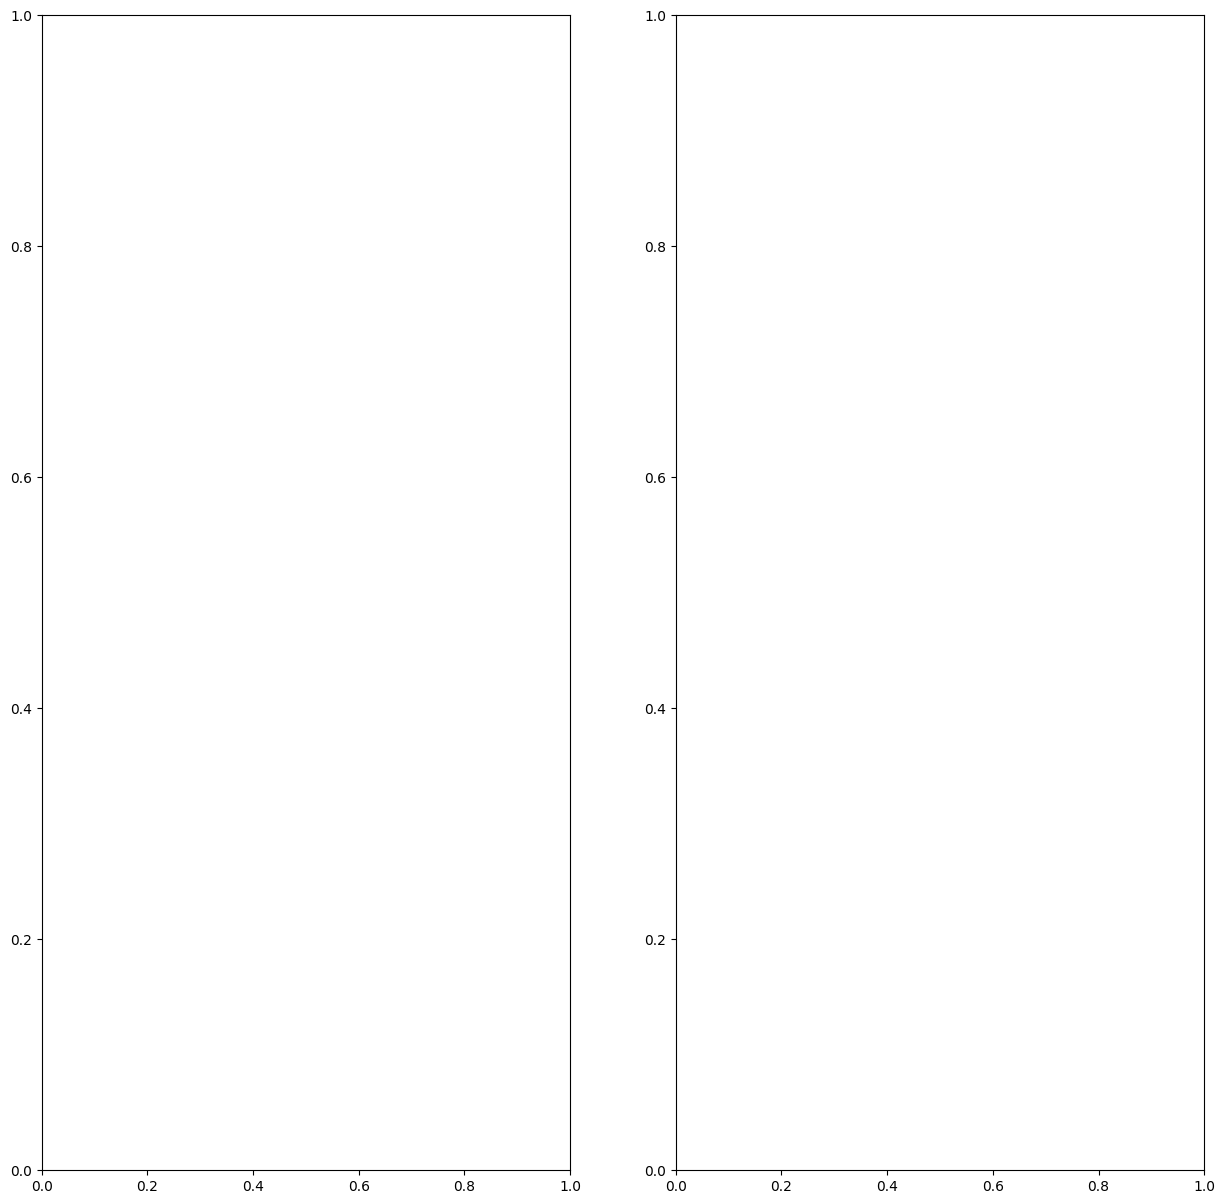

In [99]:
import math

n_routes = len(fit_gdf)
n_cols = math.ceil(math.sqrt(n_routes))
n_rows = math.ceil(n_routes / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

axes = axes.flatten()

for routes, ax in zip(fit_gdf.geometry, axes):
    gp.GeoDataFrame(geometry=[routes], crs="EPSG:4326").plot(ax=ax, linewidth=2, color='orange')
    ax.set_axis_off()

for ax in axes[n_routes:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()